## Library Imports

In [191]:
# General data manipulation and visualization
import pandas as pd  # For working with structured data
import numpy as np
import matplotlib.pyplot as plt  # For plotting and visualizations
import seaborn as sns  # For statistical data visualization
import joblib
import geopandas

# Scikit-learn modules for data processing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # Data splitting and model selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Data preprocessing
from sklearn.compose import ColumnTransformer  # Preprocessing pipelines
from sklearn.pipeline import Pipeline  # Pipeline construction
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # Evaluation metrics
from sklearn.calibration import CalibratedClassifierCV  # Calibration of probabilities
from sklearn.feature_selection import RFECV  # Recursive feature elimination with cross-validation
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, recall_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn import set_config

# Imbalanced-learn modules for handling imbalanced datasets
from imblearn.over_sampling import SMOTE  # Oversampling
from imblearn.combine import SMOTEENN, SMOTETomek  # Combined oversampling and undersampling techniques
from imblearn.under_sampling import TomekLinks  # Undersampling
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline for imbalanced datasets

# SHAP library for interpretability
import shap  # For model explanation and feature importance

# Data Loading and Preprocessing
# -----------------------------------------------------------------------------------

In [74]:
# Step 1: Load and Encode the Dataset
# -------------------------------------
# Load the dataset (assumes it is clean and preprocessed).
cdc_heart_df = pd.read_csv("heart_2022_no_nans.csv")

# Encode the target variable
# Convert the 'HadHeartAttack' column to binary (1 = 'Yes', 0 = 'No')
cdc_heart_df['HadHeartAttack'] = cdc_heart_df['HadHeartAttack'].map({'Yes': 1, 'No': 0})

In [75]:
# Step 2: Create a Reduced Dataset
# -------------------------------------
# Reduce the dataset to 5% of its original size for computational efficiency.
# This step ensures faster processing on resource-constrained hardware.
reduced_df = cdc_heart_df.sample(frac=0.05, random_state=42)

# Separate features (X) and target (y) from the reduced dataset.
X = reduced_df.drop(columns=['HadHeartAttack'])  # Features
y = reduced_df['HadHeartAttack']  # Target variable

In [76]:
# Step 3: Identify Feature Types
# -------------------------------------
# Identify categorical and numerical columns for preprocessing steps.
categorical_cols = X.select_dtypes(include=['object']).columns  # Categorical features
numerical_cols = X.select_dtypes(include=['float64']).columns  # Numerical features

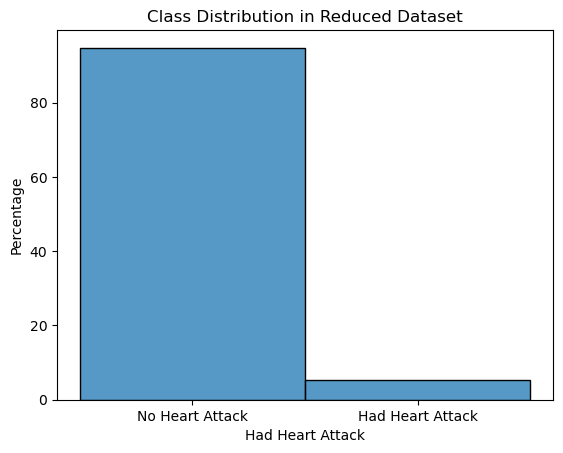

In [77]:
# Step 4: Plot Class Distribution
# -------------------------------------
# Visualize the class distribution in the reduced dataset to identify any potential class imbalance.
sns.histplot(data=reduced_df, x="HadHeartAttack", stat="percent", discrete=True)
plt.xticks([0, 1], ['No Heart Attack', 'Had Heart Attack'])
plt.title("Class Distribution in Reduced Dataset")
plt.xlabel("Had Heart Attack")
plt.ylabel("Percentage")
plt.show()

In [78]:
# Step 5: Print Dataset Summary
# -------------------------------------
# Display information about the reduced dataset to confirm its structure and size.
print("Reduced dataset information:")
print(reduced_df.info())

Reduced dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 12301 entries, 194767 to 22599
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      12301 non-null  object 
 1   Sex                        12301 non-null  object 
 2   GeneralHealth              12301 non-null  object 
 3   PhysicalHealthDays         12301 non-null  float64
 4   MentalHealthDays           12301 non-null  float64
 5   LastCheckupTime            12301 non-null  object 
 6   PhysicalActivities         12301 non-null  object 
 7   SleepHours                 12301 non-null  float64
 8   RemovedTeeth               12301 non-null  object 
 9   HadHeartAttack             12301 non-null  int64  
 10  HadAngina                  12301 non-null  object 
 11  HadStroke                  12301 non-null  object 
 12  HadAsthma                  12301 non-null  object 
 13  HadSkinCancer    

In [79]:
# Step 4: Preprocessing Pipelines
# -----------------------------------------------------------------------------------
# Ensure output is a pandas DataFrame by setting `transform_output="pandas"`
set_config(transform_output="pandas")  # This ensures all transformers return pandas DataFrames

# Define the pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Convert categorical to one-hot encoding
])

# Combine the numerical and categorical transformers into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),  # Apply scaling to numerical columns
    ('cat', categorical_transformer, categorical_cols)  # Apply one-hot encoding to categorical columns
])

In [80]:
# Step 5: Train-Test Split
# -----------------------------------------------------------------------------------
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the preprocessor to the training data and transform it
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Check the feature names after transformation
print("Transformed feature names (train):", X_train_transformed.columns)
print("Transformed feature names (test):", X_test_transformed.columns)

Transformed feature names (train): Index(['num__PhysicalHealthDays', 'num__MentalHealthDays', 'num__SleepHours',
       'num__HeightInMeters', 'num__WeightInKilograms', 'num__BMI',
       'cat__State_Alabama', 'cat__State_Alaska', 'cat__State_Arizona',
       'cat__State_Arkansas',
       ...
       'cat__PneumoVaxEver_Yes',
       'cat__TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years',
       'cat__TetanusLast10Tdap_Yes, received Tdap',
       'cat__TetanusLast10Tdap_Yes, received tetanus shot but not sure what type',
       'cat__TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap',
       'cat__HighRiskLastYear_No', 'cat__HighRiskLastYear_Yes',
       'cat__CovidPos_No',
       'cat__CovidPos_Tested positive using home test without a health professional',
       'cat__CovidPos_Yes'],
      dtype='object', length=154)
Transformed feature names (test): Index(['num__PhysicalHealthDays', 'num__MentalHealthDays', 'num__SleepHours',
       'num__HeightIn

# Training Baseline Models
# -----------------------------------------------------------------------------------

In [81]:
from sklearn.svm import SVC  # Import SVC for Support Vector Machines

# List of models and their names
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000))
]

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC-ROC': []
}

In [82]:
# Train and evaluate each model
for name, model in models:
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_transformed, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    # Append metrics to the dictionary
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['AUC-ROC'].append(auc_roc)
    
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}\n")

Training Random Forest...
Random Forest Metrics:
Accuracy: 0.9480, Precision: 0.5500, Recall: 0.0846, F1 Score: 0.1467, AUC-ROC: 0.8770

Training Gradient Boosting...
Gradient Boosting Metrics:
Accuracy: 0.9480, Precision: 0.5217, Recall: 0.1846, F1 Score: 0.2727, AUC-ROC: 0.8800

Training Naive Bayes...
Naive Bayes Metrics:
Accuracy: 0.5360, Precision: 0.0946, Recall: 0.9077, F1 Score: 0.1713, AUC-ROC: 0.8216

Training Logistic Regression...
Logistic Regression Metrics:
Accuracy: 0.9460, Precision: 0.4706, Recall: 0.1846, F1 Score: 0.2652, AUC-ROC: 0.8768



In [83]:
# Convert metrics dictionary to DataFrame for simplicity
metrics_df = pd.DataFrame(metrics)

# Check if DataFrame
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest,0.947989,0.550000,0.084615,0.146667,0.876994
1,Gradient Boosting,0.947989,0.521739,0.184615,0.272727,0.880032
2,Naive Bayes,0.535961,0.094551,0.907692,0.171263,0.821567
3,Logistic Regression,0.945957,0.470588,0.184615,0.265193,0.876775


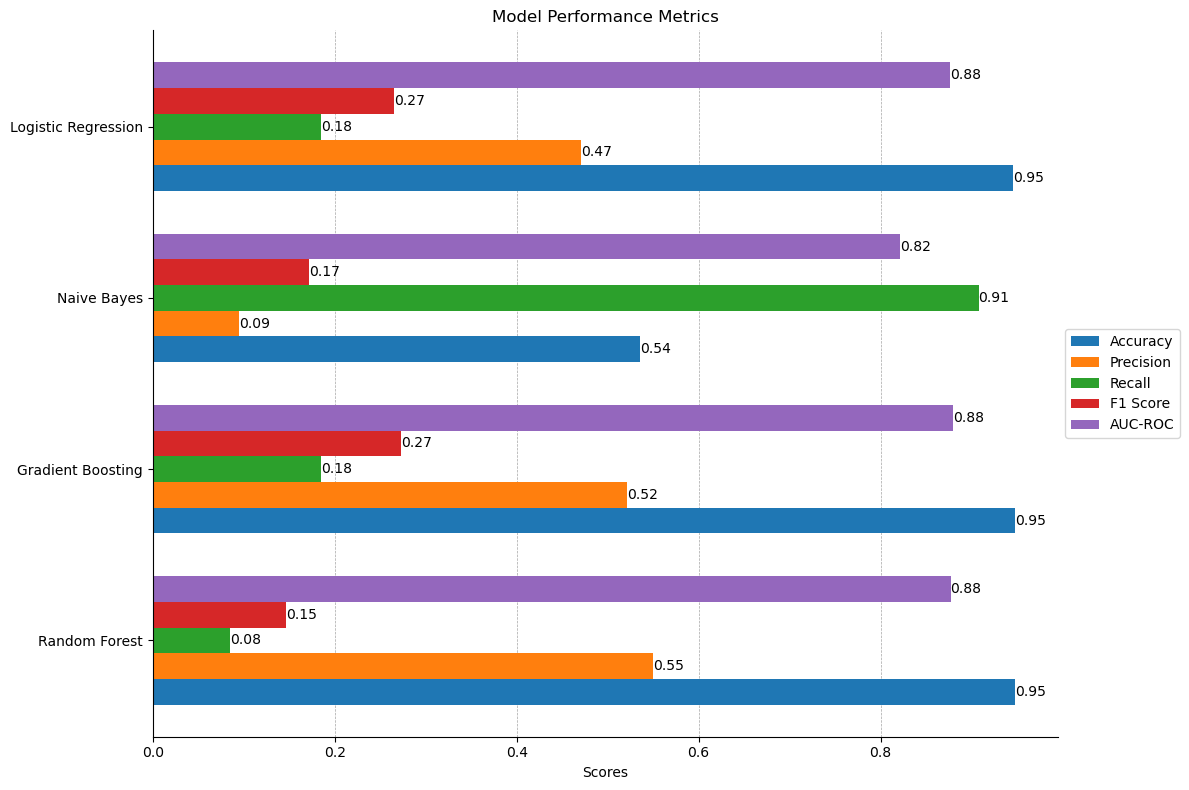

In [84]:
# Extract data for plotting
x = np.arange(len(metrics_df['Model']))  # Indices for models
width = 0.15  # Width of each bar

# Plot grouped bar chart (horizontal)
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bars dynamically based on the number of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
bar_positions = [x + i * width for i in range(-2, 3)]  # Dynamically adjust bar positions

# Plot each metric
for i, metric in enumerate(metrics):
    ax.barh(bar_positions[i], metrics_df[metric], width, label=metric)

# Add values to the bars dynamically
for i, model in enumerate(metrics_df['Model']):
    for j, metric in enumerate(metrics):
        ax.text(metrics_df[metric][i], bar_positions[j][i], 
                f"{metrics_df[metric][i]:.2f}", va='center', ha='left')

# Customize the appearance of the chart
ax.set_yticks(x)  # Set y-axis ticks
ax.set_yticklabels(metrics_df['Model'], rotation=0)  # Add model names
ax.set_xlabel('Scores')  # X-axis label
ax.set_title('Model Performance Metrics')  # Chart title

# Adjust the legend position to the right of the chart
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Move legend slightly to the right

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add dashed grid lines for x-axis
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_axisbelow(True)

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

## Objective:
The aim of this project is to predict the likelihood of heart attacks based on various health-related features. Given the imbalanced nature of the dataset, where positive cases (heart attacks) are relatively rare, model evaluation prioritises recall (to minimise false negatives) and F1 score (to balance precision and recall), alongside AUC-ROC to assess overall classification ability.

## Baseline Models Evaluated:

### Random Forest:
- **Strengths:**
  - High accuracy (0.9480) and AUC-ROC (0.8770), indicating strong overall classification ability.
  
- **Weaknesses:**
  - Very low recall (0.0846), highlighting poor performance in identifying positive cases. This is problematic given the objective of minimising false negatives in a heart attack prediction task.

### Gradient Boosting:
- **Strengths:**
  - Strong AUC-ROC (0.8800), demonstrating robust classification ability.
  - Higher recall (0.1846) and F1 score (0.2727) than Random Forest, making it more effective at identifying positive cases (heart attacks) while maintaining competitive accuracy (0.9464).
  
- **Weaknesses:**
  - Slightly lower precision (0.5217) compared to Random Forest, which could lead to more false positives.

### Naive Bayes:
- **Strengths:**
  - Excellent recall (0.9077), identifying most positive cases.
  
- **Weaknesses:**
  - Extremely low precision (0.0946), resulting in many false positives.
  - Low accuracy (0.5360) and F1 score (0.1713), making it unsuitable for practical deployment in this context.

### Logistic Regression:
- **Strengths:**
  - Simplicity and interpretability, with solid performance across metrics.
  - Competitive AUC-ROC (0.8768) and reasonable accuracy (0.9460).
  
- **Weaknesses:**
  - Recall (0.1846) and F1 score (0.2652) are lower than Gradient Boosting, making it less suitable for tackling class imbalance where false negatives need to be minimised.

## Decision to Move Forward:
Gradient Boosting is selected as the model to move forward with based on its ability to strike a strong balance across the critical metrics for this problem:

- **Recall**: The highest recall among practical models (0.1846) ensures that most positive cases are identified, which is crucial for minimising false negatives in heart attack prediction.
- **F1 Score**: Achieves a competitive F1 score (0.2727), balancing precision and recall.
- **AUC-ROC**: Competitive AUC-ROC of 0.8800, demonstrating robust classification ability.
- **Scalability**: Gradient Boosting is efficient and adaptable to further optimisation, making it suitable for real-world applications, particularly when addressing class imbalance.


# Feature Selection with RFECV
# -----------------------------------------------------------------------------------

### 1. Applying RFECV to Gradient Boosting Machine (GBM):

In [85]:
# Initialize the Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Create an RFECV object
# Using recall as the scoring metric since it is critical for minimizing false negatives
rfecv = RFECV(
    estimator=gbm_model,
    step=1,  # Number of features to remove per iteration
    cv=5,  # 5-fold cross-validation
    scoring=make_scorer(recall_score),  # Prioritize recall
    verbose=1,  # Display progress
    n_jobs=-1  # Use all available cores for computation
)

In [86]:
# Fit RFECV on the training data
rfecv.fit(X_train_transformed, y_train)

Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
F

RFECV(cv=5, estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
      scoring=make_scorer(recall_score, response_method='predict'), verbose=1)

In [87]:
# Transform the datasets to retain only the selected features
X_train_selected = rfecv.transform(X_train_transformed)
X_test_selected = rfecv.transform(X_test_transformed)  # Only need test set for final evaluation

# Print the results of RFECV
print(f"Optimal number of features selected: {rfecv.n_features_}")
print("Feature rankings (1 = selected):", rfecv.ranking_)

Optimal number of features selected: 37
Feature rankings (1 = selected): [  1  44   1   1   1   1  36  58  61  50  22  17  83   1  67   1  70  27
  98  94 102  97  95  30  56  19  52 108  42  43  63   8  54  53  28 100
  46  41  47  92  65 104   1  89   1  88   1 111 115  11  37 116  13  20
 107  12  25  40  55  87   1   1   7   1  16   1   2 112  14  78  49 118
  80  48  59   1   1   1   1   1   1  76 117   1  21  86  77  73  84   3
   1   5  91  90  64   1  96   1  57   1  66 101 103   1   1   4  35  51
  15   1  23  32   1 105  10  45 106   1   1  99   9  68   6  75  60  81
 114  39 110   1  82  85  93  31   1   1   1  38  69  74   1  29  79  24
   1  62 113  18  34 109  26  71  72  33]


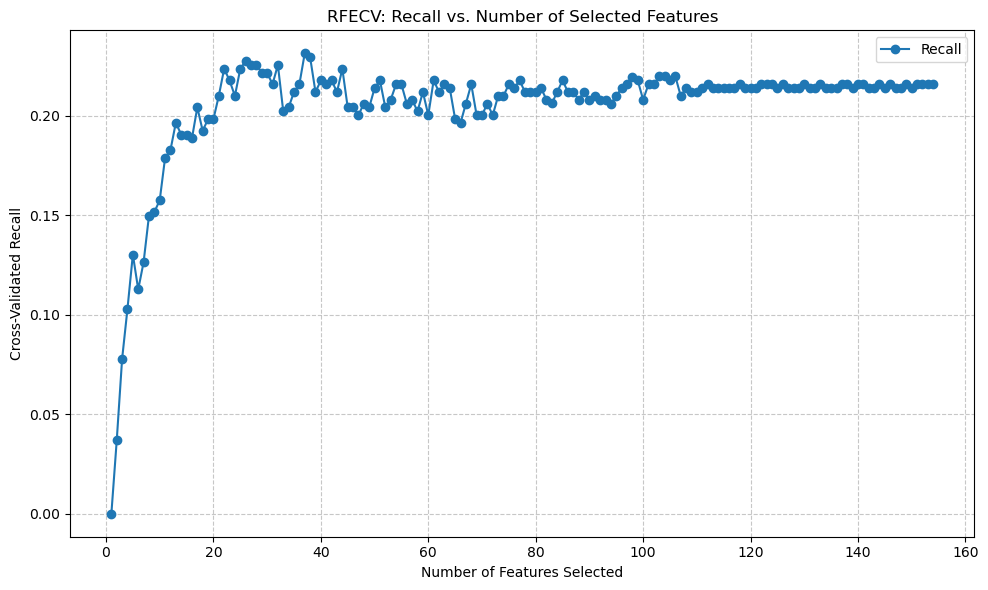

Selected features:
['num__PhysicalHealthDays' 'num__SleepHours' 'num__HeightInMeters'
 'num__WeightInKilograms' 'num__BMI' 'cat__State_Delaware'
 'cat__State_Florida' 'cat__State_Ohio' 'cat__State_Oregon'
 'cat__State_Puerto Rico' 'cat__Sex_Female' 'cat__Sex_Male'
 'cat__GeneralHealth_Fair' 'cat__GeneralHealth_Poor'
 'cat__RemovedTeeth_All' 'cat__RemovedTeeth_None of them'
 'cat__HadAngina_No' 'cat__HadAngina_Yes' 'cat__HadStroke_No'
 'cat__HadStroke_Yes' 'cat__HadSkinCancer_No' 'cat__HadKidneyDisease_Yes'
 'cat__HadDiabetes_Yes' 'cat__DeafOrHardOfHearing_No'
 'cat__BlindOrVisionDifficulty_No' 'cat__DifficultyWalking_No'
 'cat__DifficultyWalking_Yes'
 'cat__SmokerStatus_Current smoker - now smokes every day'
 'cat__SmokerStatus_Never smoked' 'cat__ChestScan_No' 'cat__ChestScan_Yes'
 'cat__AgeCategory_Age 45 to 49' 'cat__AgeCategory_Age 70 to 74'
 'cat__AgeCategory_Age 75 to 79' 'cat__AgeCategory_Age 80 or older'
 'cat__HIVTesting_Yes' 'cat__PneumoVaxEver_Yes']


In [88]:
# Visualize RFECV Results
plt.figure(figsize=(10, 6))
plt.title("RFECV: Recall vs. Number of Selected Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated Recall")

# Extract the mean test scores from cv_results_
mean_test_scores = rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o', label="Recall")

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc="best")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Retrieve selected feature names
selected_feature_indices = np.where(rfecv.support_)[0]  # Indices of selected features
selected_feature_names = np.array(preprocessor.get_feature_names_out())[selected_feature_indices]

# Print selected feature names
print("Selected features:")
print(selected_feature_names)

## Selected Features Overview

The following features were selected through Recursive Feature Elimination with Cross-Validation (RFECV), offering a refined set of variables that are highly relevant for predicting heart attacks. Below is a breakdown of these features and their potential importance:

---

### Numerical Features
1. **PhysicalHealthDays**: Reflects the number of days in the past month when physical health was poor. This is a key indicator of general well-being and can be an important risk factor for heart attacks.
2. **SleepHours**: Sleep patterns have a direct correlation with cardiovascular health. Both insufficient and excessive sleep are linked to an increased risk of heart attacks.
3. **HeightInMeters, WeightInKilograms, BMI**: These features are pivotal in assessing a person's physical profile, particularly obesity, which is a known risk factor for heart disease.

---

### Categorical Features
#### State Information
- **Delaware**, **Florida**, **Ohio**, **Oregon**, **Puerto Rico**: These states were selected, suggesting that regional factors, such as healthcare access, lifestyle habits, and socio-economic conditions, may influence the likelihood of heart attacks.
  
#### Demographic Variables
- **Sex (Male)**: Gender plays a significant role in heart disease risk, with males generally at higher risk at younger ages.
- **AgeCategory (70 to 74, 75 to 79, 80 or older)**: Age is a key determinant of heart attack risk, with older individuals being at higher risk due to age-related changes in cardiovascular health.

#### Health Conditions
- **GeneralHealth (Fair)**: Self-reported health status can be indicative of cardiovascular health, with poorer general health correlating with higher heart disease risk.
- **RemovedTeeth (None of them)**: Poor oral health, including missing teeth, has been linked to cardiovascular issues in several studies.
- **HadAngina (No, Yes)**: Angina (chest pain) is a major warning sign of underlying heart disease and an important predictor of heart attack risk.
- **HadStroke (No, Yes)**: A history of stroke often correlates with cardiovascular disease and increases the risk of future heart attacks.
- **HadDiabetes (Yes)**: Diabetes is a well-established risk factor for heart attacks and other cardiovascular complications.

#### Lifestyle and Habits
- **DifficultyWalking (No, Yes)**: Difficulty walking can be a sign of reduced cardiovascular fitness or physical limitations, both of which are linked to higher heart attack risk.
- **SmokerStatus (Current smoker - now smokes every day, Never smoked)**: Smoking is a major risk factor for heart attacks, with smokers at significantly higher risk.
- **ChestScan (No)**: Whether the individual has undergone medical screening, which could indicate existing health concerns.

---

### Insights and Next Steps
- **Relevance of Features**: The selected features are biologically and contextually relevant for predicting heart attacks. They capture key aspects of health, lifestyle, and demographic information that influence heart disease risk.
  
- **Next Steps**:
  - **Resampling**: Techniques like SMOTE (Synthetic Minority Oversampling Technique) will be applied to address the class imbalance in the dataset.
  - **Model Fine-tuning**: Hyperparameter tuning (using GridSearchCV or RandomizedSearchCV) will be conducted for the Gradient Boosting model to further optimise performance.
  - **Model Interpretation**: SHAP values will be computed to interpret the influence of the selected features on the model's predictions and gain insights into he model's decision-making process.

---


In [89]:
# Update the training, validation, and test datasets
X_train_selected = rfecv.transform(X_train_transformed)
X_test_selected = rfecv.transform(X_test_transformed)

# Resampling Techniques
# -----------------------------------------------------------------------------------

In [90]:
# Define the resampling techniques
resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Dictionary to store evaluation metrics
resampling_metrics = {
    'Resampler': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC-ROC': []
}

In [91]:
# Loop through each resampling technique
for name, resampler in resamplers.items():
    print(f"Evaluating {name}...")
    
    # Resample the training data
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_selected, y_train)
    
    # Initialize the Gradient Boosting Model
    gbm_model = GradientBoostingClassifier(random_state=42)
    
    # Train the model on the resampled data
    gbm_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred = gbm_model.predict(X_test_selected)
    y_prob = gbm_model.predict_proba(X_test_selected)[:, 1]  # Predicted probabilities for ROC-AUC
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    
    # Append metrics to the dictionary
    resampling_metrics['Resampler'].append(name)
    resampling_metrics['Accuracy'].append(accuracy)
    resampling_metrics['Precision'].append(precision)
    resampling_metrics['Recall'].append(recall)
    resampling_metrics['F1 Score'].append(f1)
    resampling_metrics['AUC-ROC'].append(auc_roc)
    
    # Print metrics for the current resampler
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}\n")

Evaluating SMOTE...
SMOTE Metrics:
Accuracy: 0.9431, Precision: 0.4479, Recall: 0.3308, F1 Score: 0.3805, AUC-ROC: 0.8566

Evaluating SMOTEENN...
SMOTEENN Metrics:
Accuracy: 0.9346, Precision: 0.4025, Recall: 0.4923, F1 Score: 0.4429, AUC-ROC: 0.8717

Evaluating SMOTETomek...
SMOTETomek Metrics:
Accuracy: 0.9419, Precision: 0.4356, Recall: 0.3385, F1 Score: 0.3810, AUC-ROC: 0.8607



In [92]:
# Convert the results to a DataFrame for easier visualization
resampling_metrics_df = pd.DataFrame(resampling_metrics)

# Display the DataFrame
print(resampling_metrics_df)

    Resampler  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0       SMOTE  0.943113   0.447917  0.330769  0.380531  0.856648
1    SMOTEENN  0.934579   0.402516  0.492308  0.442907  0.871683
2  SMOTETomek  0.941894   0.435644  0.338462  0.380952  0.860707


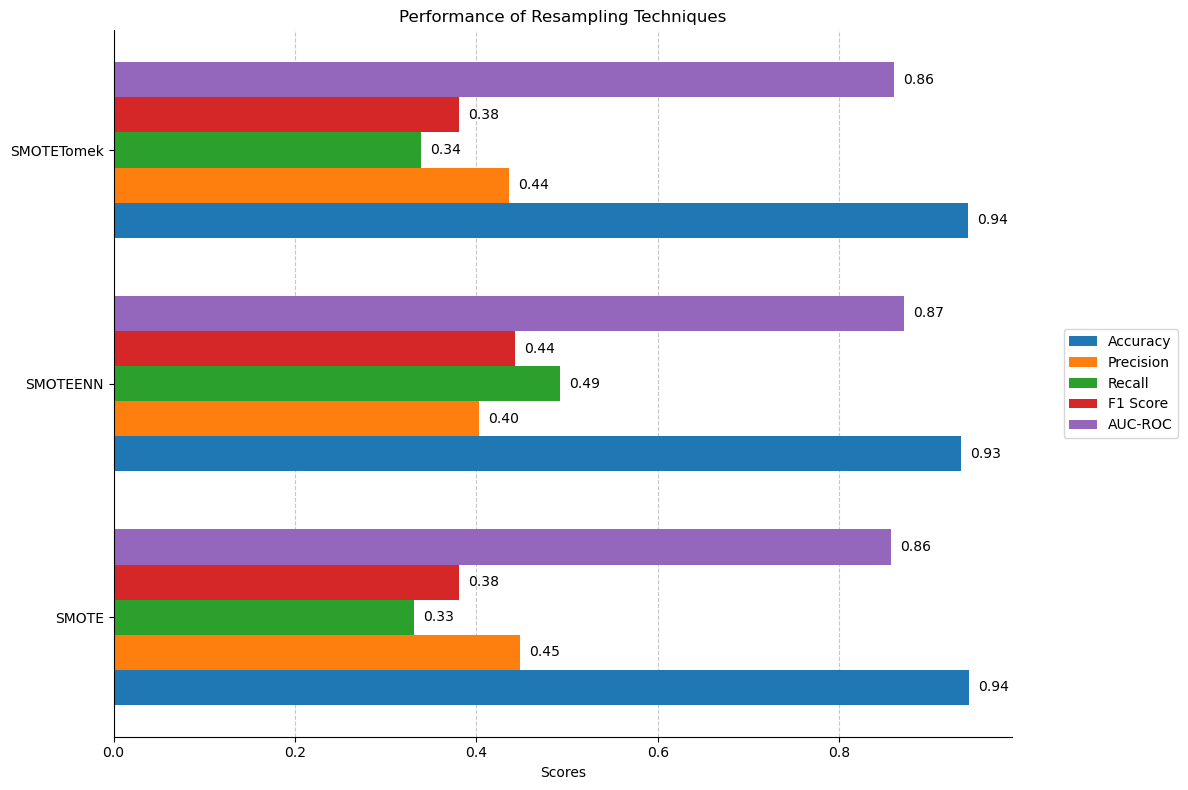

In [187]:
# Extract data for plotting
resampling_methods = resampling_metrics_df['Resampler']  # Use the correct column name
x = np.arange(len(resampling_methods))  # Indices for sampling methods
width = 0.15  # Width of each bar

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bars for each metric
ax.barh(x - 2*width, resampling_metrics_df['Accuracy'], width, label='Accuracy', color='C0')
ax.barh(x - width, resampling_metrics_df['Precision'], width, label='Precision', color='C1')
ax.barh(x, resampling_metrics_df['Recall'], width, label='Recall', color='C2')
ax.barh(x + width, resampling_metrics_df['F1 Score'], width, label='F1 Score', color='C3')
ax.barh(x + 2*width, resampling_metrics_df['AUC-ROC'], width, label='AUC-ROC', color='C4')

# Annotate values beside the bars
for i in range(len(resampling_methods)):
    ax.text(resampling_metrics_df['Accuracy'][i] + 0.01, x[i] - 2*width, 
            f"{resampling_metrics_df['Accuracy'][i]:.2f}", va='center', ha='left')
    ax.text(resampling_metrics_df['Precision'][i] + 0.01, x[i] - width, 
            f"{resampling_metrics_df['Precision'][i]:.2f}", va='center', ha='left')
    ax.text(resampling_metrics_df['Recall'][i] + 0.01, x[i], 
            f"{resampling_metrics_df['Recall'][i]:.2f}", va='center', ha='left')
    ax.text(resampling_metrics_df['F1 Score'][i] + 0.01, x[i] + width, 
            f"{resampling_metrics_df['F1 Score'][i]:.2f}", va='center', ha='left')
    ax.text(resampling_metrics_df['AUC-ROC'][i] + 0.01, x[i] + 2*width, 
            f"{resampling_metrics_df['AUC-ROC'][i]:.2f}", va='center', ha='left')

# Customize the appearance of the chart
ax.set_yticks(x)  # Set y-axis ticks
ax.set_yticklabels(resampling_methods, rotation=0)  # Add resampling method names
ax.set_xlabel('Scores')  # X-axis label
ax.set_title('Performance of Resampling Techniques')  # Chart title

# Move legend to the right of the chart
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))  # Adjust position to the right

# Remove unnecessary borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid lines for y-axis
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


### **Resampling Techniques Evaluation Summary**

The following three resampling techniques were evaluated using the Gradient Boosting model: **SMOTE**, **SMOTEENN**, and **SMOTETomek**. These techniques were applied to address class imbalance in the dataset, and the models were assessed based on several performance metrics, including **Accuracy**, **Precision**, **Recall**, **F1 Score**, and **AUC-ROC**.

---

#### **1. SMOTE (Synthetic Minority Over-sampling Technique)**

- **Accuracy**: 0.9431
- **Precision**: 0.4479
- **Recall**: 0.3308
- **F1 Score**: 0.3805
- **AUC-ROC**: 0.8566

**Strengths**:
- High accuracy, indicating a good overall performance.
- Balanced approach, with a reasonable **AUC-ROC**.

**Weaknesses**:
- Moderate **Recall** and **F1 Score**, suggesting that although the model is accurate, it is not very effective at identifying all positive cases (heart attacks), which is important for this task.

---

#### **2. SMOTEENN (SMOTE + Edited Nearest Neighbours)**

- **Accuracy**: 0.9346
- **Precision**: 0.4025
- **Recall**: 0.4923
- **F1 Score**: 0.4429
- **AUC-ROC**: 0.8717

**Strengths**:
- The highest **Recall** (0.4923), making it the most effective technique at identifying positive cases (heart attacks), which is critical for minimizing false negatives.
- The **F1 Score** is also the highest among the three techniques, indicating a good balance between precision and recall.

**Weaknesses**:
- Slightly lower **Accuracy** compared to **SMOTE**, suggesting that the model is more focused on recall at the expense of overall performance.

---

#### **3. SMOTETomek (SMOTE + Tomek Links)**

- **Accuracy**: 0.9419
- **Precision**: 0.4356
- **Recall**: 0.3385
- **F1 Score**: 0.3810
- **AUC-ROC**: 0.8607

**Strengths**:
- Similar to **SMOTE**, this technique offers competitive accuracy and AUC-ROC scores.

**Weaknesses**:
- Lower **Recall** compared to **SMOTEENN**, which means it is less effective at identifying positive cases.
- The **F1 Score** and **Precision** are also slightly lower than **SMOTEENN**, indicating it might be less effective in balancing precision and recall.

---

### **Recommendation:**

**SMOTEENN** should be the preferred resampling technique to move forward with. It performs best in terms of **Recall** and **F1 Score**, which are crucial for this heart attack prediction task where identifying as many positive cases (heart attacks) as possible is of utmost importance. 

Although its **Accuracy** is slightly lower than **SMOTE**, the trade-off is justified because **Recall** is more critical for this application, ensuring that the model does not miss potential heart attack cases. The **AUC-ROC** of 0.8717 further supports its robustness in classification.

Therefore, **SMOTEENN** is the most suitable resampling technique to address class imbalance and should be used in the next steps of the pipeline, particularly for model fine-tuning and further evaluation.


In [96]:
# Apply SMOTENN to the selected features
smotenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smotenn.fit_resample(X_train_selected, y_train)

# Hyperparameter Tuning with GridSearchCV
# -----------------------------------------------------------------------------------

In [95]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'max_depth': [3, 5, 7],           # Maximum depth of the individual estimators
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'subsample': [0.8, 1.0],          # Fraction of samples used for fitting individual trees
    'min_samples_split': [2, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be a leaf node
}

# Initialize the Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

In [96]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbm_model,
    param_grid=param_grid,
    scoring='recall',  # Prioritize recall to minimize false negatives
    cv=5,              # 5-fold cross-validation
    verbose=2,         # Show progress
    n_jobs=-1          # Use all available processors
)

# Fit GridSearchCV on the resampled training data
try:
    print("Starting GridSearchCV with SMOTENN...")
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Retrieve the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the results
    print("Best Hyperparameters:", best_params)
    print("Best Recall Score from GridSearchCV:", best_score)

    # Optional: Get the best estimator (model with best hyperparameters)
    best_model = grid_search.best_estimator_
    print("Best Model:", best_model)

except Exception as e:
    print(f"An error occurred during GridSearchCV: {e}")

Starting GridSearchCV with SMOTENN...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Recall Score from GridSearchCV: 0.9559247603815486
Best Model: GradientBoostingClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=5,
                           random_state=42, subsample=0.8)


# Model Calibration
# -----------------------------------------------------------------------------------

In [99]:
# Step 1: Initialize the calibrated classifier with the fine-tuned model
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)

# Step 2: Fit the calibrated classifier on the training data
calibrated_model.fit(X_train_selected, y_train)

# Step 3: Predict probabilities on the test set
y_prob_calibrated = calibrated_model.predict_proba(X_test_selected)[:, 1]
y_pred_calibrated = calibrated_model.predict(X_test_selected)

# Step 4: Evaluate calibrated performance
print("Calibrated Model Performance:")
print(classification_report(y_test, y_pred_calibrated))

# Step 5: AUC-ROC and Log Loss for the calibrated model
auc_roc_calibrated = roc_auc_score(y_test, y_prob_calibrated)
log_loss_calibrated = log_loss(y_test, y_prob_calibrated)

print(f"Calibrated AUC-ROC: {auc_roc_calibrated:.4f}")
print(f"Log Loss (Calibrated): {log_loss_calibrated:.4f}")

# Step 6: Calculate Log Loss for the uncalibrated model (fine-tuned model)
y_prob_fine_tuned = best_model.predict_proba(X_test_selected)[:, 1]
log_loss_fine_tuned = log_loss(y_test, y_prob_fine_tuned)

print(f"Log Loss (Fine-Tuned, Uncalibrated): {log_loss_fine_tuned:.4f}")

Calibrated Model Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2331
           1       0.59      0.10      0.17       130

    accuracy                           0.95      2461
   macro avg       0.77      0.55      0.57      2461
weighted avg       0.93      0.95      0.93      2461

Calibrated AUC-ROC: 0.8529
Log Loss (Calibrated): 0.1550
Log Loss (Fine-Tuned, Uncalibrated): 0.1666


# Housekeeping
# -----------------------------------------------------------------------------------

#### Saving model and data

In [140]:
final_model = calibrated_model

In [139]:
# Step 1: Save the calibrated model (final model)
joblib.dump(final_model, 'final_gbm_model_calibrated.pkl')
print("Final calibrated model saved!")

# Step 2: Save the selected features (from RFECV or feature selection)
np.savetxt('selected_features.csv', selected_feature_names, delimiter=",", fmt='%s')
print("Selected features saved!")

# Step 3: Save the preprocessing pipeline (if needed)
joblib.dump(preprocessor, 'preprocessor_pipeline.pkl')  # Save preprocessor
print("Preprocessing pipeline saved!")

# Optional: Save your training/test data if required
X_test.to_csv('test_data.csv', index=False)  # If you want to reload test data (optional)
print("Test data saved!")

Final calibrated model saved!
Selected features saved!
Preprocessing pipeline saved!
Test data saved!


## Computing SHAP values

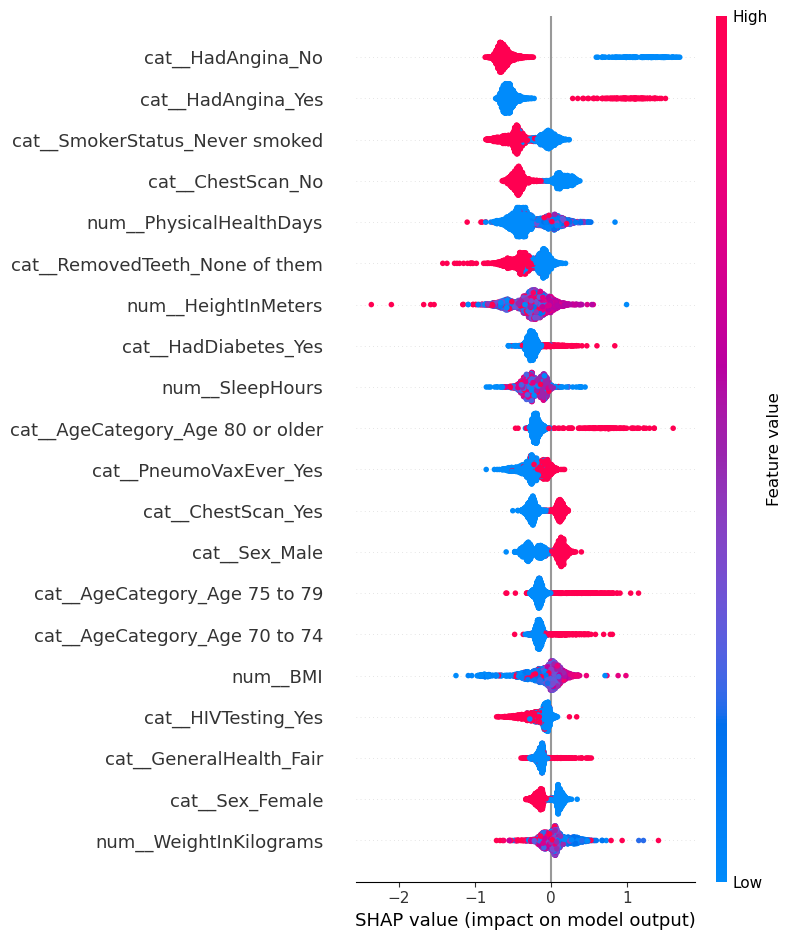

<Figure size 640x480 with 0 Axes>

In [124]:
# Step 1: Use the best model (the model with the best hyperparameters) directly
explainer = shap.TreeExplainer(best_model)  # For tree-based models like Gradient Boosting

# Step 2: Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_selected)

# Step 3: Visualise the SHAP summary plot
summary_plot_file = "shap_summary_plot.png"
shap_summary = shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)

# Save the summary plot
plt.savefig(summary_plot_file)

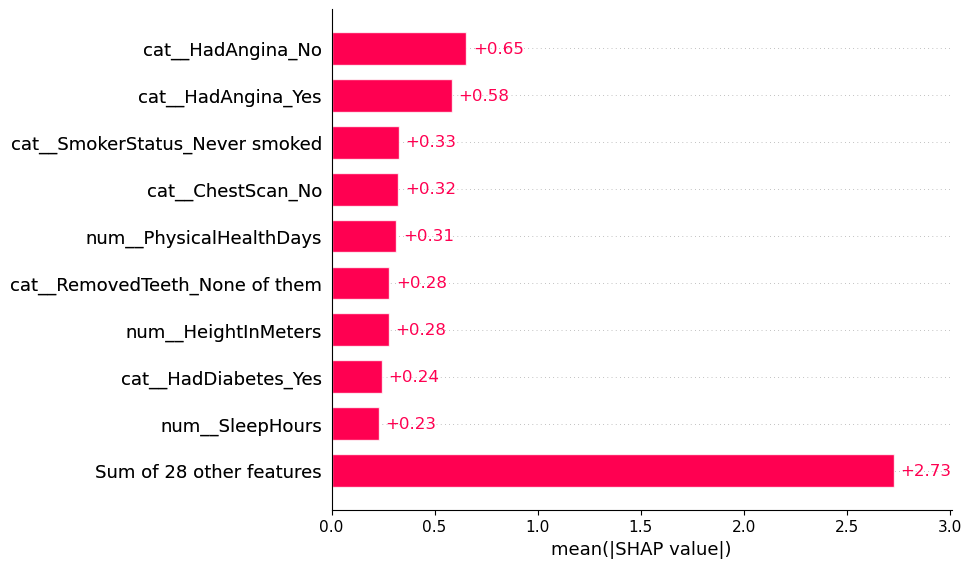

<Figure size 640x480 with 0 Axes>

In [125]:
# Step 4: Generate SHAP bar plot to visualize global feature importance
bar_plot_file = "shap_bar_plot.png"

# Wrap shap_values in an Explanation object for the bar plot
shap_values_explanation = shap.Explanation(values=shap_values, data=X_test_selected, feature_names=selected_feature_names)

# Now, plot the bar plot
shap_bar = shap.plots.bar(shap_values_explanation)

# Save the bar plot
plt.savefig(bar_plot_file)

## Creating predictive geographic map

In [176]:
def create_comparative_risk_maps(X_test, y_prob):
    # Create overall state data
    state_data_all = pd.DataFrame({
        'State': X_test['State'],
        'predicted_prob': y_prob
    })
    
    # Create elderly state data (65+)
    elderly_mask = X_test['AgeCategory'].isin(['Age 65 to 69', 'Age 70 to 74', 
                                             'Age 75 to 79', 'Age 80 or older'])
    state_data_elderly = pd.DataFrame({
        'State': X_test[elderly_mask]['State'],
        'predicted_prob': y_prob[elderly_mask]
    })
    
    # Calculate average probabilities
    state_probs_all = state_data_all.groupby('State')['predicted_prob'].mean().reset_index()
    state_probs_elderly = state_data_elderly.groupby('State')['predicted_prob'].mean().reset_index()
    
    # Load US states shapefile
    gdf = gpd.read_file("cb_2018_us_state_500k.shp")
    
    # Create state name mapping
    state_name_mapping = {
        'Virgin Islands': 'United States Virgin Islands'
    }
    
    # Apply mapping to both datasets
    state_probs_all['State'] = state_probs_all['State'].replace(state_name_mapping)
    state_probs_elderly['State'] = state_probs_elderly['State'].replace(state_name_mapping)
    
    # Merge shapefile with probability data
    merged_gdf_all = gdf.merge(state_probs_all, 
                              left_on='NAME', 
                              right_on='State', 
                              how='left')
    
    merged_gdf_elderly = gdf.merge(state_probs_elderly, 
                                  left_on='NAME', 
                                  right_on='State', 
                                  how='left')
    
    # Create figure with two sets of axes
    fig = plt.figure(figsize=(25, 12))
    
    # Create axes for left map (all ages) with enlarged insets
    ax_main_left = fig.add_axes([0.02, 0.12, 0.45, 0.8])
    ax_alaska_left = fig.add_axes([0.02, 0.25, 0.12, 0.12])  # Enlarged
    ax_hawaii_left = fig.add_axes([0.10, 0.25, 0.09, 0.09])  # Moved closer to Alaska and enlarged
    
    # Create axes for right map (elderly) with enlarged insets
    ax_main_right = fig.add_axes([0.52, 0.12, 0.45, 0.8])
    ax_alaska_right = fig.add_axes([0.52, 0.25, 0.12, 0.12])  # Enlarged
    ax_hawaii_right = fig.add_axes([0.60, 0.25, 0.09, 0.09])  # Moved closer to Alaska and enlarged
    
    def plot_map_set(merged_gdf, ax_main, ax_alaska, ax_hawaii, title):
        # Split into regions
        cont_us = merged_gdf[~merged_gdf['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico', 
                                                      'United States Virgin Islands', 'Guam', 
                                                      'American Samoa', 
                                                      'Commonwealth of the Northern Mariana Islands'])]
        alaska = merged_gdf[merged_gdf['NAME'] == 'Alaska']
        hawaii = merged_gdf[merged_gdf['NAME'] == 'Hawaii']
        
        # Set projections
        cont_us = cont_us.to_crs('EPSG:5070')
        alaska = alaska.to_crs('EPSG:3338')
        hawaii = hawaii.to_crs('EPSG:3759')
        
        # Plot contiguous US
        cont_us.plot(column='predicted_prob',
                    cmap='RdYlBu_r',
                    linewidth=0.8,
                    edgecolor='0.8',
                    legend=True,
                    legend_kwds={'label': 'Heart Attack Risk Probability',
                               'orientation': 'vertical',
                               'shrink': 0.5},
                    missing_kwds={'color': 'lightgrey'},
                    ax=ax_main)
        
        # Plot Alaska
        alaska.plot(column='predicted_prob',
                   cmap='RdYlBu_r',
                   linewidth=0.8,
                   edgecolor='0.8',
                   ax=ax_alaska)
        
        # Plot Hawaii
        hawaii.plot(column='predicted_prob',
                    cmap='RdYlBu_r',
                    linewidth=0.8,
                    edgecolor='0.8',
                    ax=ax_hawaii)
        
        # Customize axes
        ax_main.axis('off')
        ax_alaska.axis('off')
        ax_hawaii.axis('off')
        
        # Add statistics
        stats = merged_gdf[merged_gdf['predicted_prob'].notna()]
        stats_text = (f"Highest: {stats['State'][stats['predicted_prob'].idxmax()]} "
                     f"({stats['predicted_prob'].max():.1%})\n"
                     f"Lowest: {stats['State'][stats['predicted_prob'].idxmin()]} "
                     f"({stats['predicted_prob'].min():.1%})\n"
                     f"Mean: {stats['predicted_prob'].mean():.1%}")
        
        ax_main.text(0.02, 0.98, stats_text,
                    transform=ax_main.transAxes,
                    fontsize=8,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        # Add subtitle
        ax_main.set_title(title, pad=20, fontsize=14)
    
    # Plot both sets of maps
    plot_map_set(merged_gdf_all, ax_main_left, ax_alaska_left, ax_hawaii_left, 
                 "Heart Attack Risk - All Ages")
    plot_map_set(merged_gdf_elderly, ax_main_right, ax_alaska_right, ax_hawaii_right, 
                 "Heart Attack Risk - Age 65+")
    
    # Add main title
    plt.suptitle('Geographic Distribution of Heart Attack Risk by Age Group', 
                 fontsize=16, y=0.95)
    
    return fig

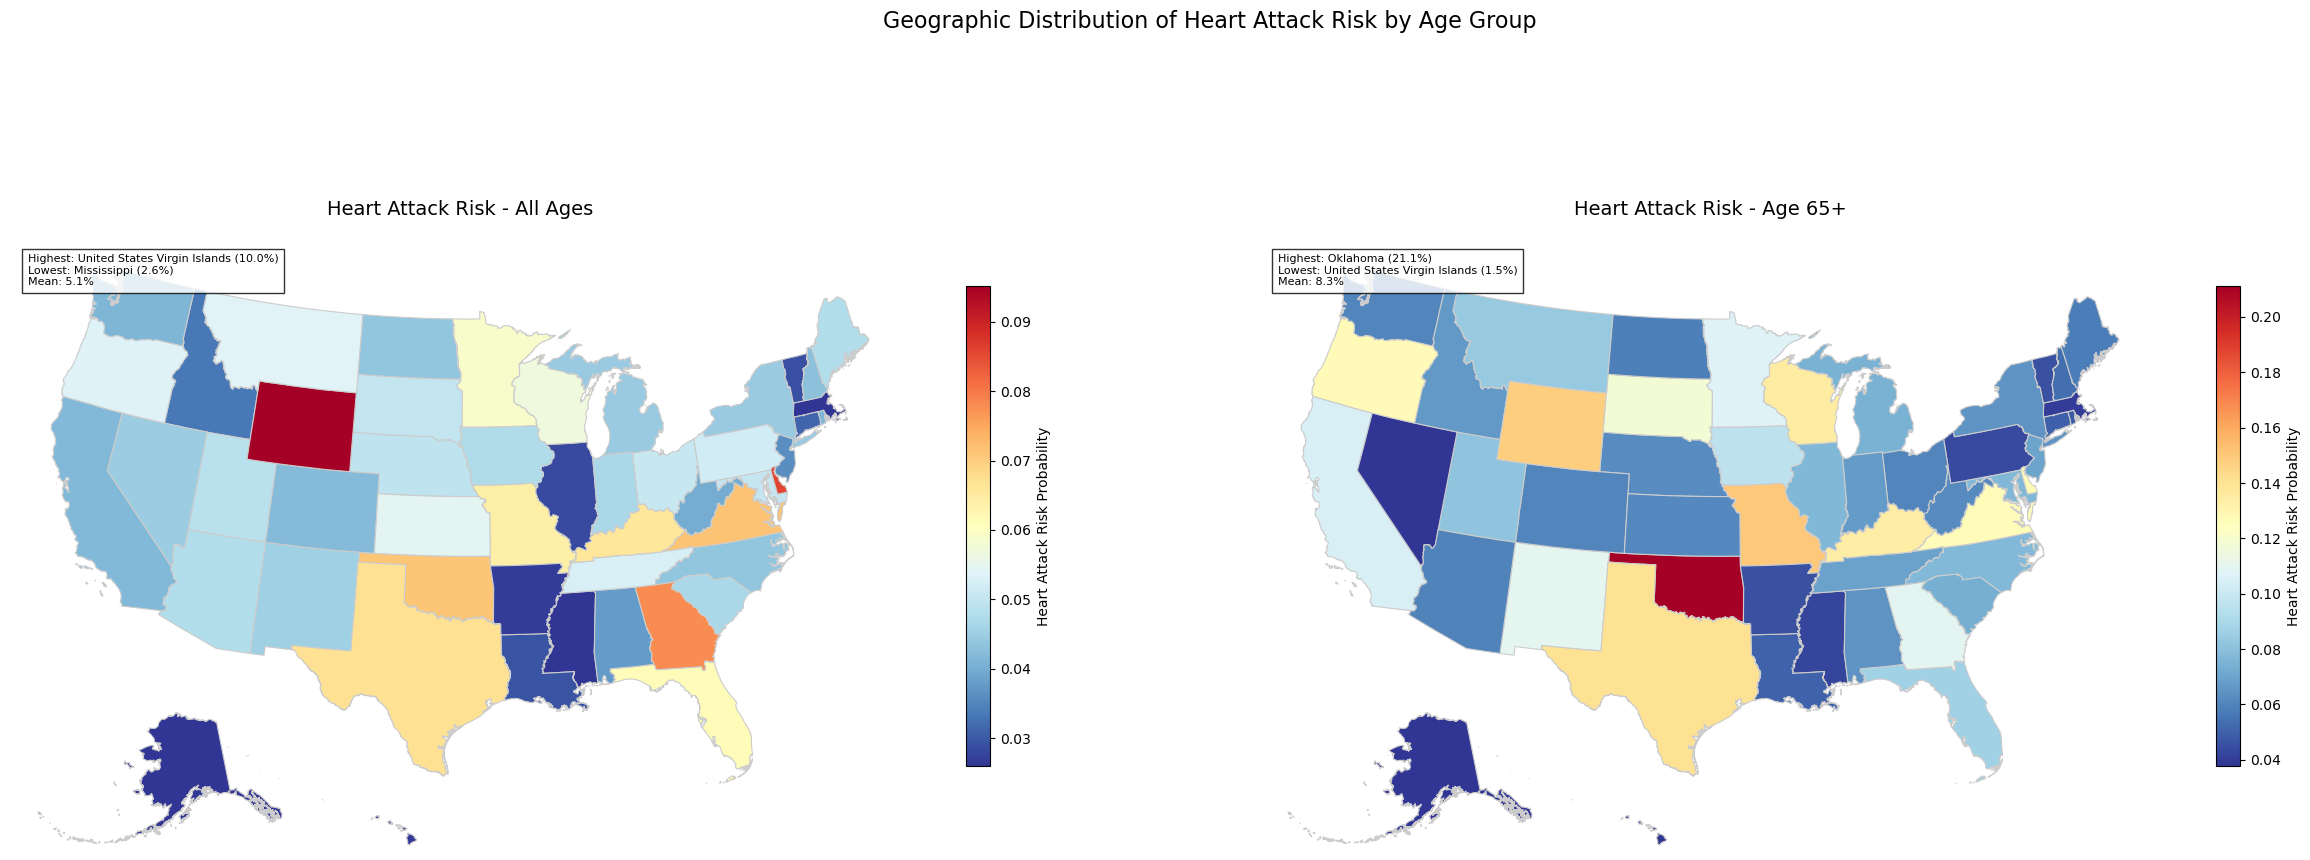

In [190]:
# Create and save the comparative maps
fig = create_comparative_risk_maps(X_test, y_prob_calibrated)
plt.savefig('heart_attack_risk_comparison.png', 
            bbox_inches='tight', 
            dpi=600,
            pad_inches=0.5)
plt.show()

In [188]:
def create_state_probability_charts(X_test, y_prob_calibrated):
    # Create DataFrame for all ages
    state_data_all = pd.DataFrame({
        'State': X_test['State'],
        'predicted_prob': y_prob
    })
    
    # Create data for elderly (65+)
    elderly_mask = X_test['AgeCategory'].isin(['Age 65 to 69', 'Age 70 to 74', 
                                             'Age 75 to 79', 'Age 80 or older'])
    state_data_elderly = pd.DataFrame({
        'State': X_test[elderly_mask]['State'],
        'predicted_prob': y_prob[elderly_mask]
    })
    
    # Calculate state means
    state_probs_all = state_data_all.groupby('State')['predicted_prob'].mean().sort_values(ascending=True)
    state_probs_elderly = state_data_elderly.groupby('State')['predicted_prob'].mean().sort_values(ascending=True)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    
    # Plot all ages
    state_probs_all.plot(kind='barh', ax=ax1)
    ax1.set_title('Heart Attack Risk by State - All Ages', pad=20)
    ax1.set_xlabel('Probability')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot elderly
    state_probs_elderly.plot(kind='barh', ax=ax2)
    ax2.set_title('Heart Attack Risk by State - Age 65+', pad=20)
    ax2.set_xlabel('Probability')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Customize appearance
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add value labels
        for i, v in enumerate(ax.patches):
            ax.text(v.get_width(), i, f'{v.get_width():.3f}', 
                   va='center', fontsize=8)
    
    # Adjust the y-position of the overall title to move it slightly lower
    plt.suptitle('State-Level Heart Attack Risk Probabilities', fontsize=16, y=.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Slightly adjust the top margin to make room for the suptitle
    
    return fig


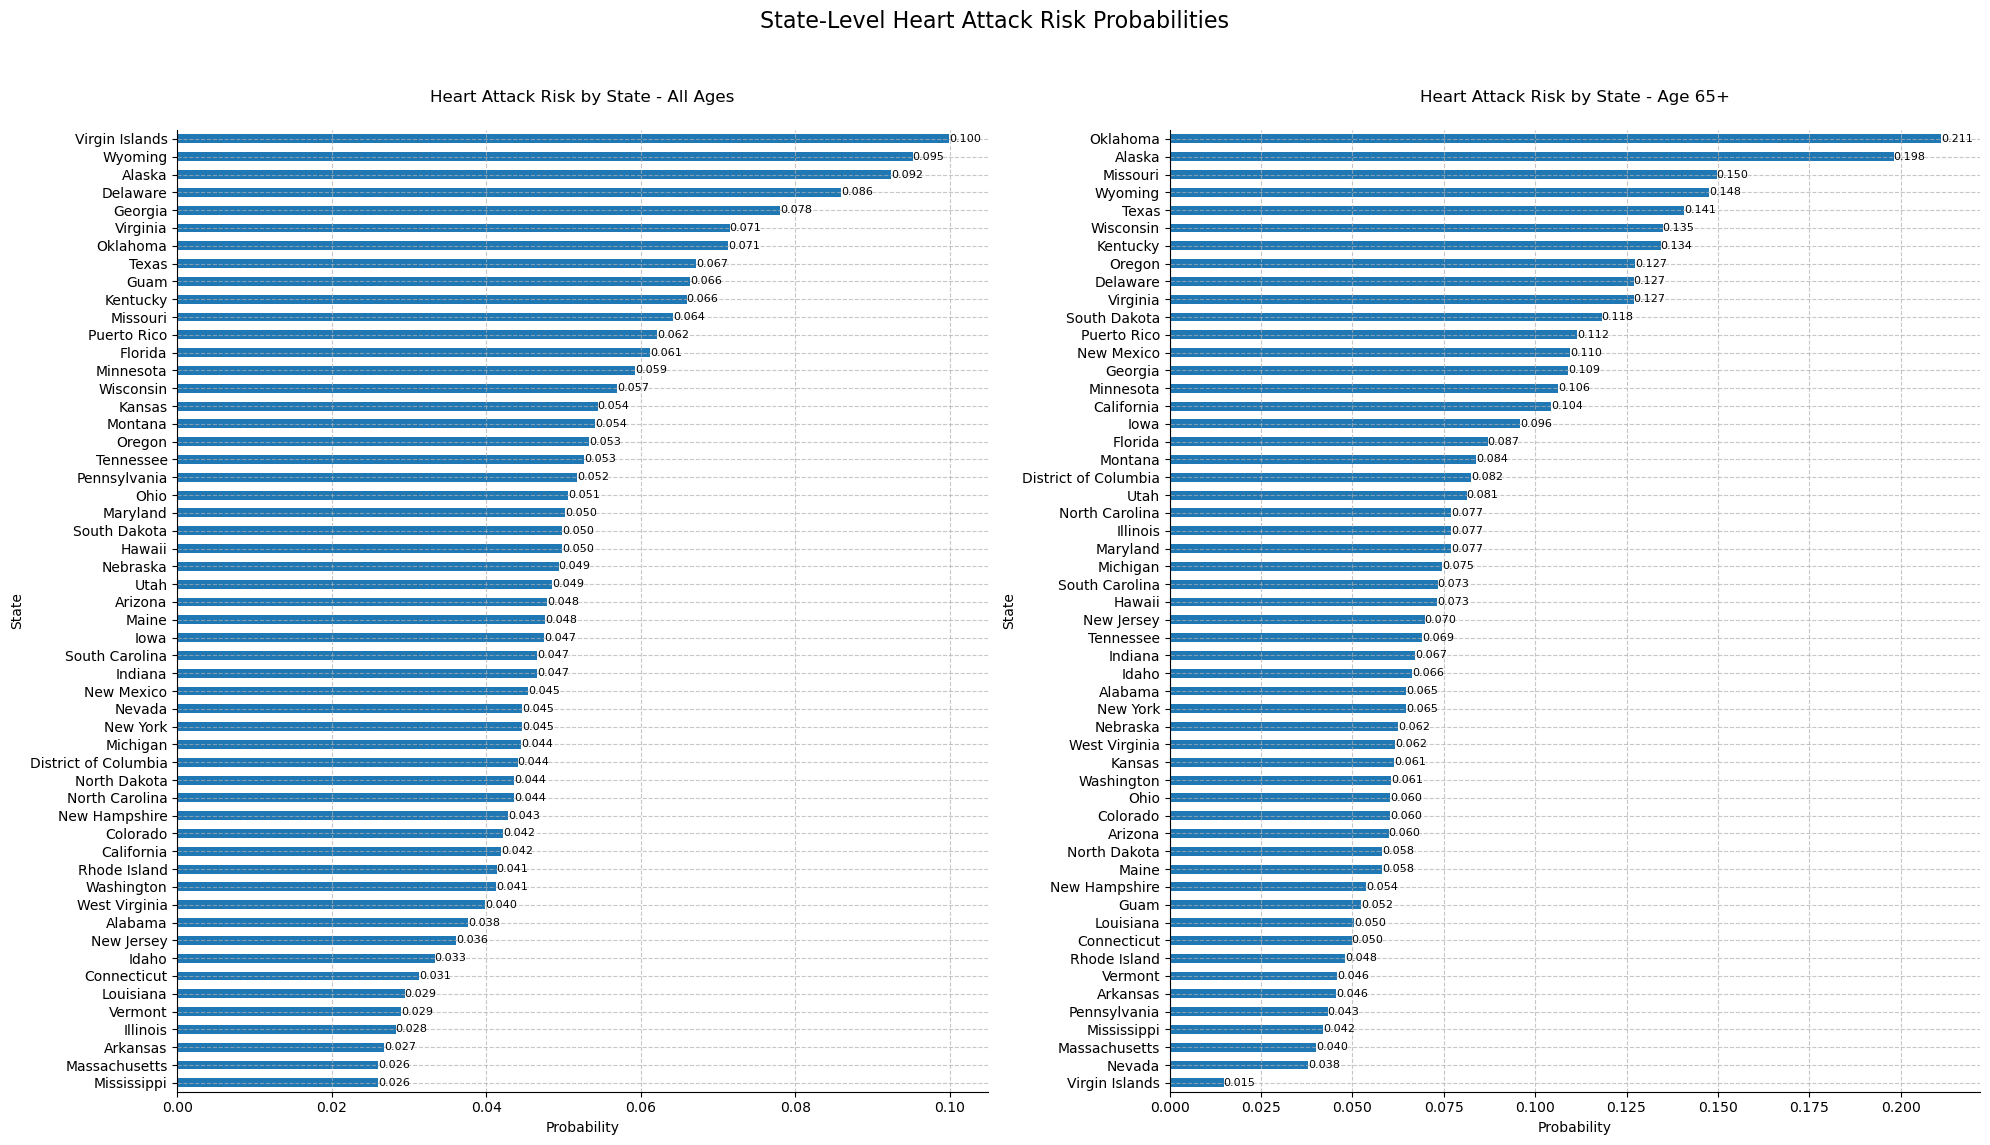

In [189]:
# Create and save the charts
fig = create_state_probability_charts(X_test, y_prob_test)
plt.savefig('state_probabilities.png', 
            bbox_inches='tight', 
            dpi=300,
            pad_inches=0.5)
plt.show()